#### El jugador más “retador” y el jugador más “retado”.

1. Hacemos uso de un job que cuenta tanto retadores como retados, su mapper escribe dos veces según el tipo de jugador y el reducer contabiliza cada jugador y según su tipo (hacemos uso de una función combiner con la misma lógica para aprovechar todo el procesamiento que se pueda hacer en el mismo cluster y minimizar la cantidad datos que se envian).
2. El segundo job tomara la salida del primero como su entrada y se encargara de determinar de acuerdo a RETADOR o RETADO el max de lo que acabamos de contar. Este segundo Job es necesario porque los jugadores son BIG DATA. El mapper no hace nada, es el reducer quien lo calcula. Idealmente deberia de haber dos reducer uno para la Key RETADOR y otro para RETADO

Con un  Dag resultante de este estilo:
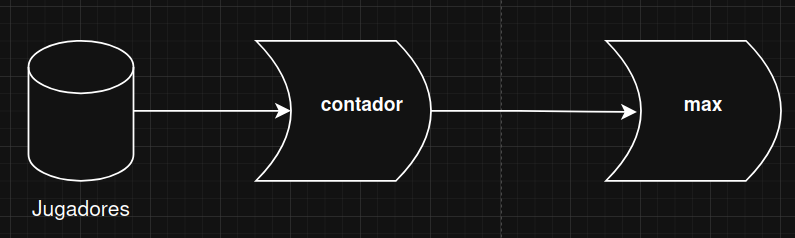


# Primer Job

In [1]:
from MRE import Job
inputDir = "./jugadores/"
outputDir = "./retadoresContados/"

In [ ]:
def fmap(key, value, context):
    # por cada linea genero dos con clave tipo + id y valor 1
    retador = int(key)
    parts = value.split('	')
    context.write(('RETADOR', retador), 1)
    retado = int(parts[0])
    context.write(('RETADO', retado), 1)

def fcombiner(key, values, context):
    # suma los conteos localmente antes de enviarlos al reducer
    s = 0
    for v in values:
        s += int(v)
    context.write(key, s)

def fred(key, values, context):
    # recibe (TYPE, player_id) y un valor >= 1 (en base a si se ejecuto el combiner o no)
    s = 0
    for v in values:
        s += int(v)
    context.write(key, s)

jobCountBoth = Job(inputDir, outputDir, fmap, fred)
jobCountBoth.setCombiner(fcombiner)
success = jobCountBoth.waitForCompletion()

print(success)

True


# Segundo Job 
Recibe la salida del primer job del tipo: TYPE	player	count. TYPE es considerado la KEY, el jugador recae en value

In [3]:
inputDir = "./retadoresContados/"
outputDir = "./output2/"

In [4]:
def fmap_max(key, value, context):
    context.write(key, value)

def fred_max(key, values, context):
    max_count = -1
    max_player = None
    for v in values:
        parts = v.split('	')
        player = int(parts[0])
        cnt = int(parts[1])
        if cnt > max_count:
            max_count = cnt
            max_player = player
    context.write(key, (max_player, max_count))

jobMax = Job(inputDir, outputDir, fmap_max, fred_max)
success = jobMax.waitForCompletion()

print(success)

True
